# 全区域

最终特征列表: ['Precip', 'NDVI', 'Avg Temp', 'RoadFV', 'RoadPT', 'TFT', 'TPT', 'NBP', 'NOT', 'TAP', 'RailFV', 'RailPT', 'UREC', 'IE', 'TRCGNG', 'TEC', 'WSV', 'TLS', 'Tot Res LPG', 'Tot Gas Supply']
最终特征数量: 20
最终 X 数据列名: ['Precip', 'NDVI', 'Avg Temp', 'RoadFV', 'RoadPT', 'TFT', 'TPT', 'NBP', 'NOT', 'TAP', 'RailFV', 'RailPT', 'UREC', 'IE', 'TRCGNG', 'TEC', 'WSV', 'TLS', 'Tot Res LPG', 'Tot Gas Supply']
最终 X 特征数量: 20


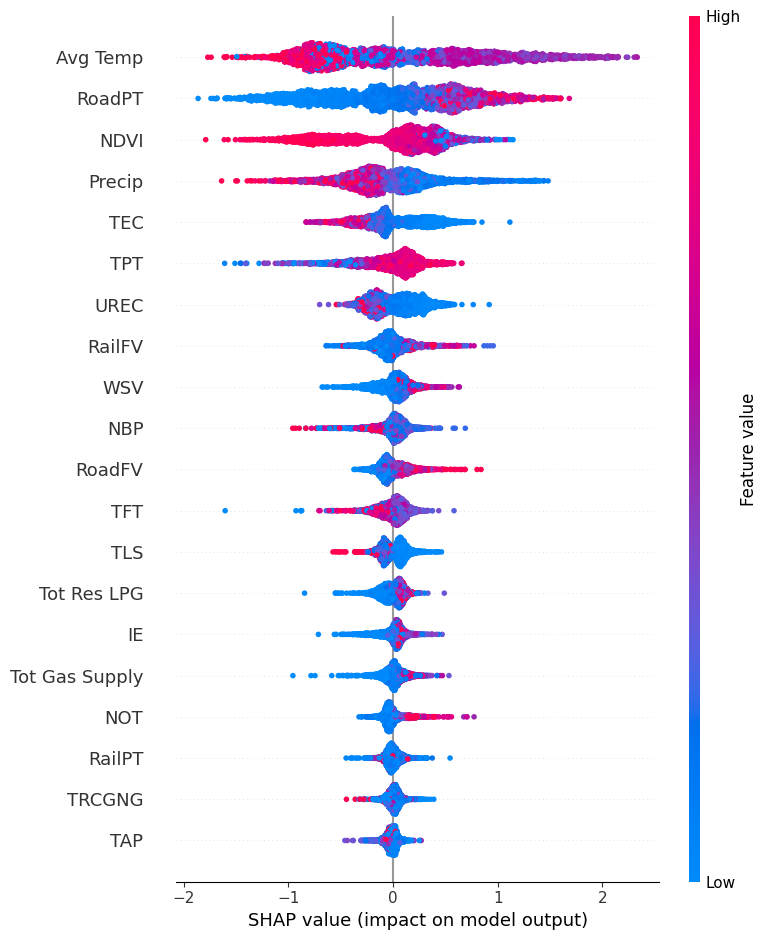

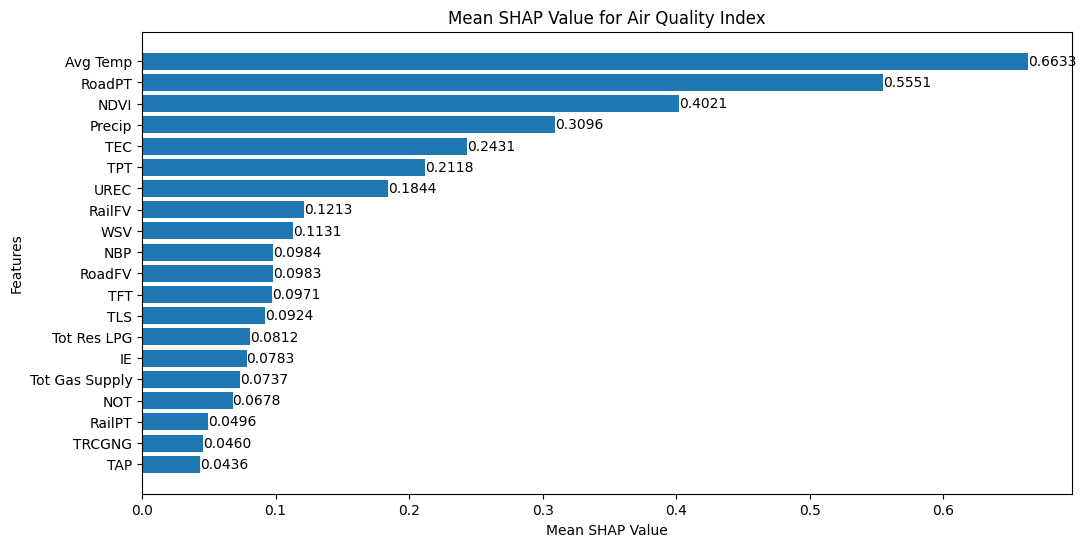

In [7]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 确保最终特征数量正确
print("最终特征列表:", feature_columns)
print("最终特征数量:", len(feature_columns))
assert len(feature_columns) == 20, f"特征数量不匹配，当前数量: {len(feature_columns)}，应为20"

# 合并 X 数据（自然环境、交通、能源）
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex"]].merge(x_data, on=["city", "year"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 选择特征和目标变量
X = final_data_cleaned[feature_columns]
Y = final_data_cleaned["AirQualityIndex"]

# 处理非数值列
X = X.select_dtypes(include=[np.number])

# 确保包含全部20个特征
# 强制转换所有特征列为数值类型
for col in feature_columns:
    final_data_cleaned[col] = pd.to_numeric(final_data_cleaned[col], errors="coerce")

# 选择特征列
X = final_data_cleaned[feature_columns]

# 确保最终特征数量正确
print("最终 X 数据列名:", X.columns.tolist())
print("最终 X 特征数量:", X.shape[1])
assert X.shape[1] == 20, f"特征数量不匹配，当前数量: {X.shape[1]}，应为20"


# 训练 XGBoost 模型
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, Y)

# 计算 SHAP 值
explainer = shap.Explainer(model)
shap_values = explainer(X)

# 绘制 SHAP 值图
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X, max_display=20)
plt.show()

# 计算 SHAP 值的均值
shap_means = np.abs(shap_values.values).mean(axis=0)
shap_mean_df = pd.DataFrame({"Feature": X.columns, "Mean SHAP Value": shap_means})
shap_mean_df = shap_mean_df.sort_values(by="Mean SHAP Value", ascending=False)

# 绘制 SHAP 均值图，并在旁边标明具体数值
plt.figure(figsize=(12, 6))
plt.barh(shap_mean_df["Feature"], shap_mean_df["Mean SHAP Value"])
plt.xlabel("Mean SHAP Value")
plt.ylabel("Features")
plt.title("Mean SHAP Value for Air Quality Index")
plt.gca().invert_yaxis()

# 在图形旁边标明具体数值
for index, value in enumerate(shap_mean_df["Mean SHAP Value"]):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.show()


# 东部区域

最终 X 数据列名: ['Precip', 'NDVI', 'Avg Temp', 'RoadFV', 'RoadPT', 'TFT', 'TPT', 'NBP', 'NOT', 'TAP', 'RailFV', 'RailPT', 'UREC', 'IE', 'TRCGNG', 'TEC', 'WSV', 'TLS', 'Tot Res LPG', 'Tot Gas Supply']
最终 X 特征数量: 20


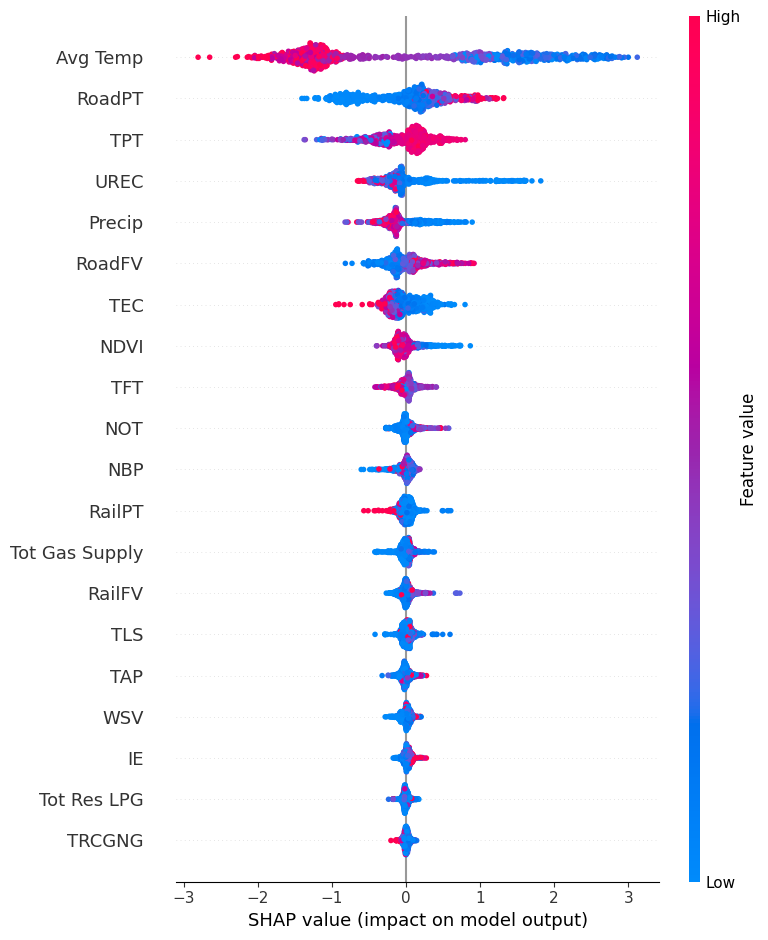

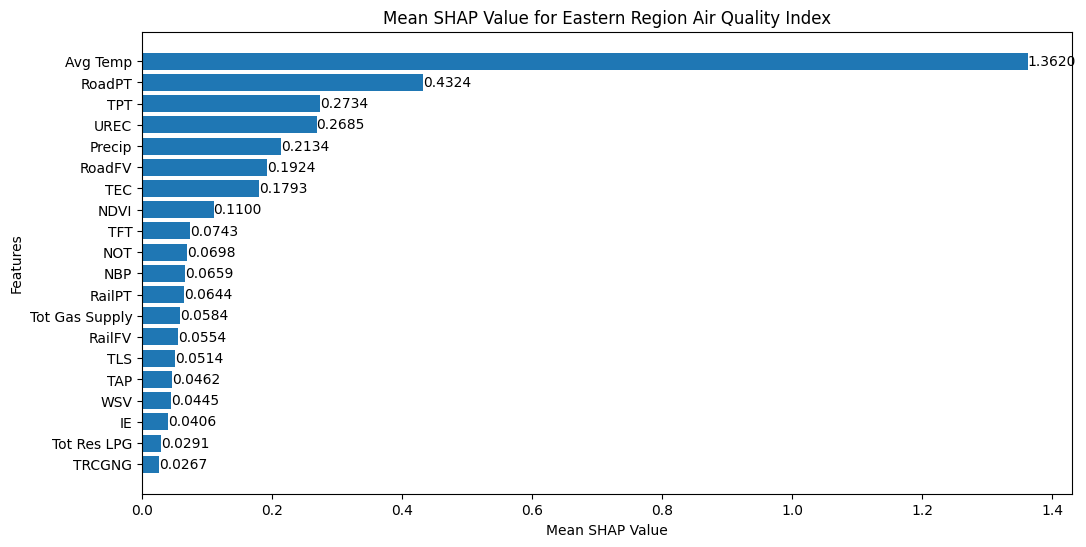

In [2]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 合并 X 数据（自然环境、交通、能源）
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year", "quyu"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex", "quyu"]].merge(x_data, on=["city", "year", "quyu"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 提取东部区域数据
final_data_cleaned = final_data_cleaned[final_data_cleaned["quyu"] == "东部"]

# 选择特征和目标变量
X = final_data_cleaned[feature_columns]
Y = final_data_cleaned["AirQualityIndex"]

# 处理非数值列
X = X.select_dtypes(include=[np.number])

# 确保包含全部20个特征
# 强制转换所有特征列为数值类型
for col in feature_columns:
    final_data_cleaned[col] = pd.to_numeric(final_data_cleaned[col], errors="coerce")

# 选择特征列
X = final_data_cleaned[feature_columns]

# 确保最终特征数量正确
print("最终 X 数据列名:", X.columns.tolist())
print("最终 X 特征数量:", X.shape[1])
assert X.shape[1] == 20, f"特征数量不匹配，当前数量: {X.shape[1]}，应为20"

# 训练 XGBoost 模型
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, Y)

# 计算 SHAP 值
explainer = shap.Explainer(model)
shap_values = explainer(X)

# 绘制 SHAP 值图
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X, max_display=20)
plt.show()

# 计算 SHAP 值的均值
shap_means = np.abs(shap_values.values).mean(axis=0)
shap_mean_df = pd.DataFrame({"Feature": X.columns, "Mean SHAP Value": shap_means})
shap_mean_df = shap_mean_df.sort_values(by="Mean SHAP Value", ascending=False)

# 绘制 SHAP 均值图，并在旁边标明具体数值
plt.figure(figsize=(12, 6))
plt.barh(shap_mean_df["Feature"], shap_mean_df["Mean SHAP Value"])
plt.xlabel("Mean SHAP Value")
plt.ylabel("Features")
plt.title("Mean SHAP Value for Eastern Region Air Quality Index")
plt.gca().invert_yaxis()

# 在图形旁边标明具体数值
for index, value in enumerate(shap_mean_df["Mean SHAP Value"]):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.show()


# 东北区域

最终 X 数据列名: ['Precip', 'NDVI', 'Avg Temp', 'RoadFV', 'RoadPT', 'TFT', 'TPT', 'NBP', 'NOT', 'TAP', 'RailFV', 'RailPT', 'UREC', 'IE', 'TRCGNG', 'TEC', 'WSV', 'TLS', 'Tot Res LPG', 'Tot Gas Supply']
最终 X 特征数量: 20


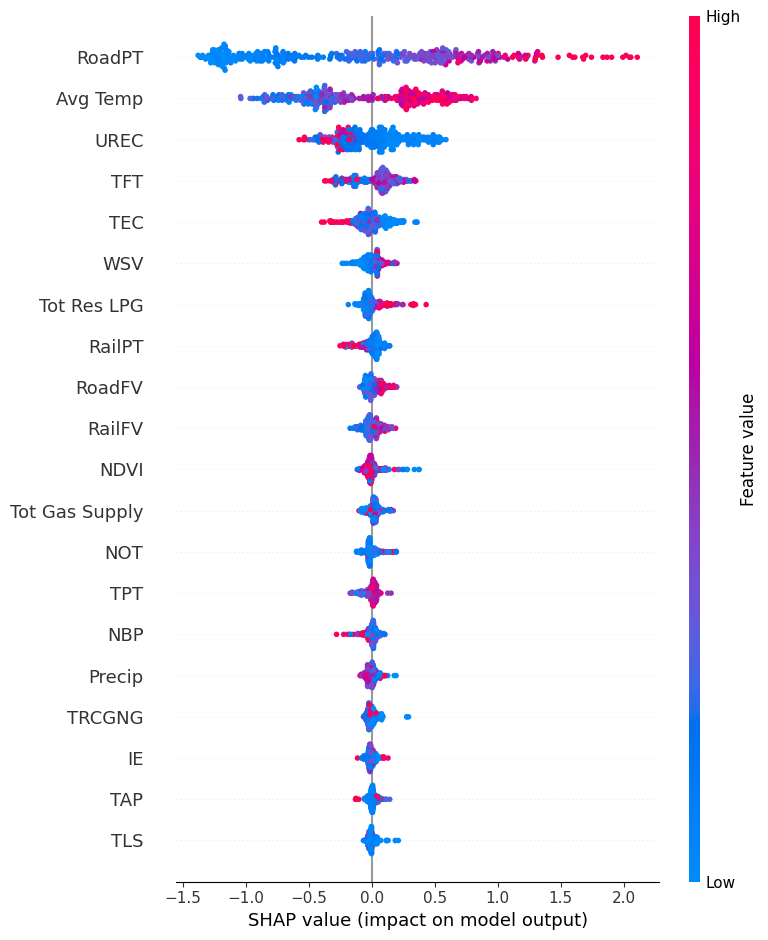

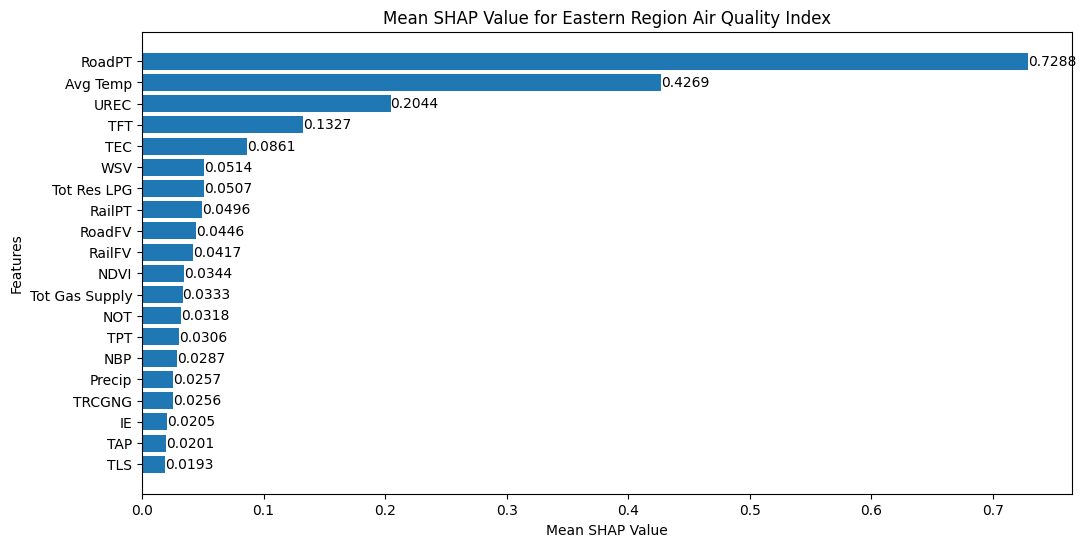

In [4]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 合并 X 数据（自然环境、交通、能源）
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year", "quyu"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex", "quyu"]].merge(x_data, on=["city", "year", "quyu"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 提取东部区域数据
final_data_cleaned = final_data_cleaned[final_data_cleaned["quyu"] == "东北"]

# 选择特征和目标变量
X = final_data_cleaned[feature_columns]
Y = final_data_cleaned["AirQualityIndex"]

# 处理非数值列
X = X.select_dtypes(include=[np.number])

# 确保包含全部20个特征
# 强制转换所有特征列为数值类型
for col in feature_columns:
    final_data_cleaned[col] = pd.to_numeric(final_data_cleaned[col], errors="coerce")

# 选择特征列
X = final_data_cleaned[feature_columns]

# 确保最终特征数量正确
print("最终 X 数据列名:", X.columns.tolist())
print("最终 X 特征数量:", X.shape[1])
assert X.shape[1] == 20, f"特征数量不匹配，当前数量: {X.shape[1]}，应为20"

# 训练 XGBoost 模型
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, Y)

# 计算 SHAP 值
explainer = shap.Explainer(model)
shap_values = explainer(X)

# 绘制 SHAP 值图
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X, max_display=20)
plt.show()

# 计算 SHAP 值的均值
shap_means = np.abs(shap_values.values).mean(axis=0)
shap_mean_df = pd.DataFrame({"Feature": X.columns, "Mean SHAP Value": shap_means})
shap_mean_df = shap_mean_df.sort_values(by="Mean SHAP Value", ascending=False)

# 绘制 SHAP 均值图，并在旁边标明具体数值
plt.figure(figsize=(12, 6))
plt.barh(shap_mean_df["Feature"], shap_mean_df["Mean SHAP Value"])
plt.xlabel("Mean SHAP Value")
plt.ylabel("Features")
plt.title("Mean SHAP Value for Eastern Region Air Quality Index")
plt.gca().invert_yaxis()

# 在图形旁边标明具体数值
for index, value in enumerate(shap_mean_df["Mean SHAP Value"]):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.show()


# 中部区域

最终 X 数据列名: ['Precip', 'NDVI', 'Avg Temp', 'RoadFV', 'RoadPT', 'TFT', 'TPT', 'NBP', 'NOT', 'TAP', 'RailFV', 'RailPT', 'UREC', 'IE', 'TRCGNG', 'TEC', 'WSV', 'TLS', 'Tot Res LPG', 'Tot Gas Supply']
最终 X 特征数量: 20


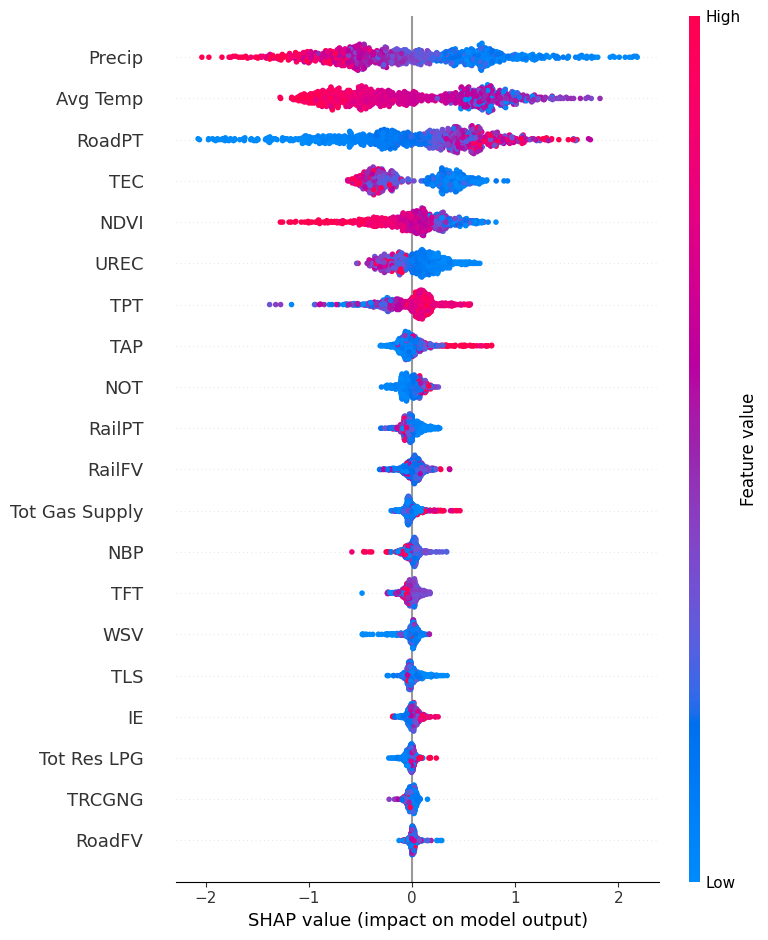

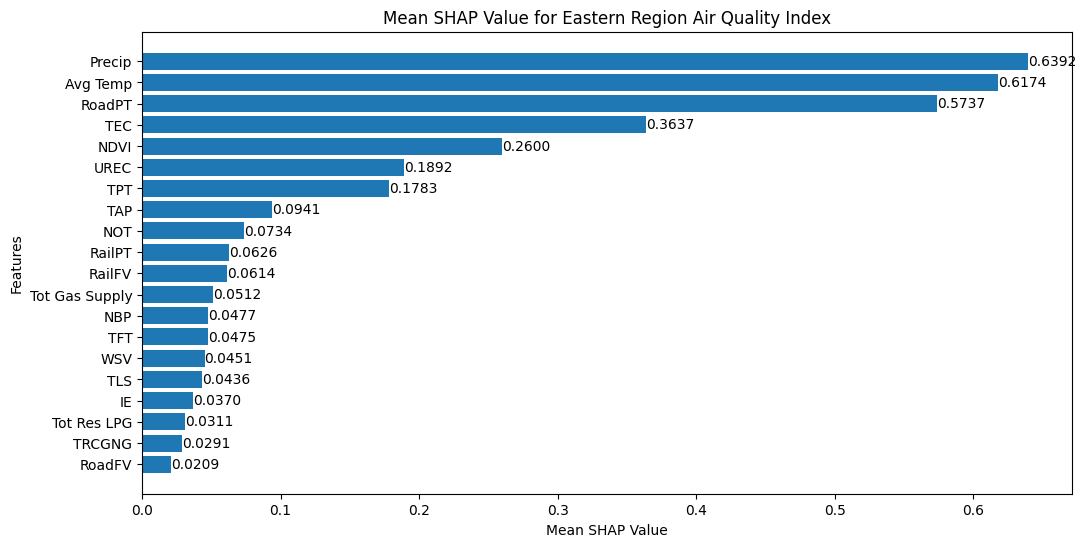

In [5]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 合并 X 数据（自然环境、交通、能源）
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year", "quyu"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex", "quyu"]].merge(x_data, on=["city", "year", "quyu"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 提取东部区域数据
final_data_cleaned = final_data_cleaned[final_data_cleaned["quyu"] == "中部"]

# 选择特征和目标变量
X = final_data_cleaned[feature_columns]
Y = final_data_cleaned["AirQualityIndex"]

# 处理非数值列
X = X.select_dtypes(include=[np.number])

# 确保包含全部20个特征
# 强制转换所有特征列为数值类型
for col in feature_columns:
    final_data_cleaned[col] = pd.to_numeric(final_data_cleaned[col], errors="coerce")

# 选择特征列
X = final_data_cleaned[feature_columns]

# 确保最终特征数量正确
print("最终 X 数据列名:", X.columns.tolist())
print("最终 X 特征数量:", X.shape[1])
assert X.shape[1] == 20, f"特征数量不匹配，当前数量: {X.shape[1]}，应为20"

# 训练 XGBoost 模型
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, Y)

# 计算 SHAP 值
explainer = shap.Explainer(model)
shap_values = explainer(X)

# 绘制 SHAP 值图
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X, max_display=20)
plt.show()

# 计算 SHAP 值的均值
shap_means = np.abs(shap_values.values).mean(axis=0)
shap_mean_df = pd.DataFrame({"Feature": X.columns, "Mean SHAP Value": shap_means})
shap_mean_df = shap_mean_df.sort_values(by="Mean SHAP Value", ascending=False)

# 绘制 SHAP 均值图，并在旁边标明具体数值
plt.figure(figsize=(12, 6))
plt.barh(shap_mean_df["Feature"], shap_mean_df["Mean SHAP Value"])
plt.xlabel("Mean SHAP Value")
plt.ylabel("Features")
plt.title("Mean SHAP Value for Eastern Region Air Quality Index")
plt.gca().invert_yaxis()

# 在图形旁边标明具体数值
for index, value in enumerate(shap_mean_df["Mean SHAP Value"]):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.show()


# 西部

最终 X 数据列名: ['Precip', 'NDVI', 'Avg Temp', 'RoadFV', 'RoadPT', 'TFT', 'TPT', 'NBP', 'NOT', 'TAP', 'RailFV', 'RailPT', 'UREC', 'IE', 'TRCGNG', 'TEC', 'WSV', 'TLS', 'Tot Res LPG', 'Tot Gas Supply']
最终 X 特征数量: 20


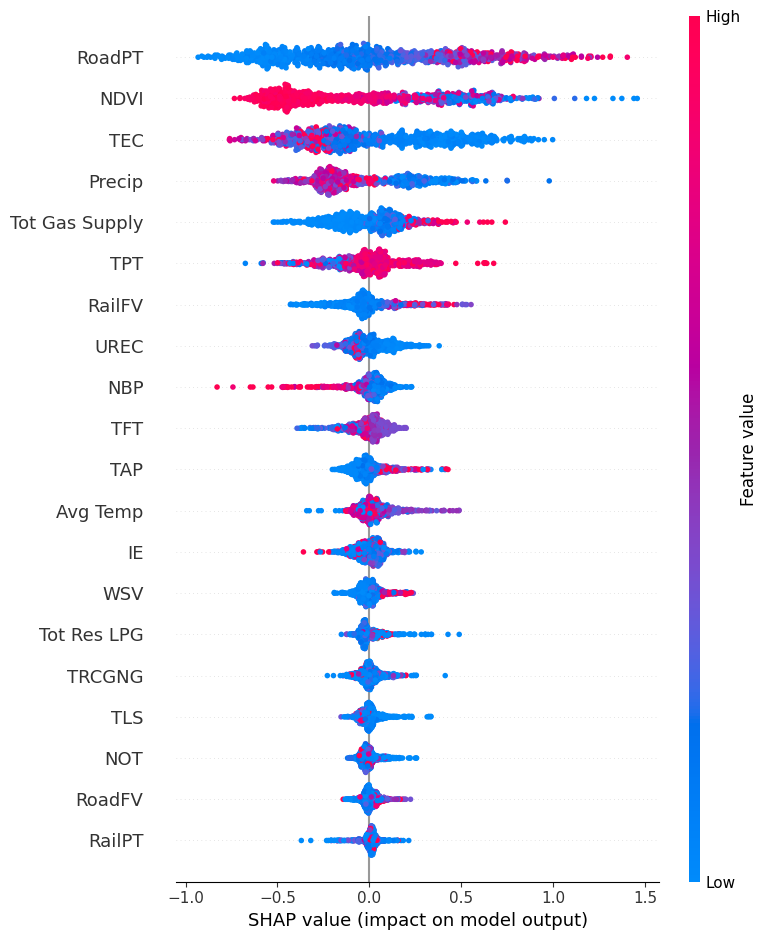

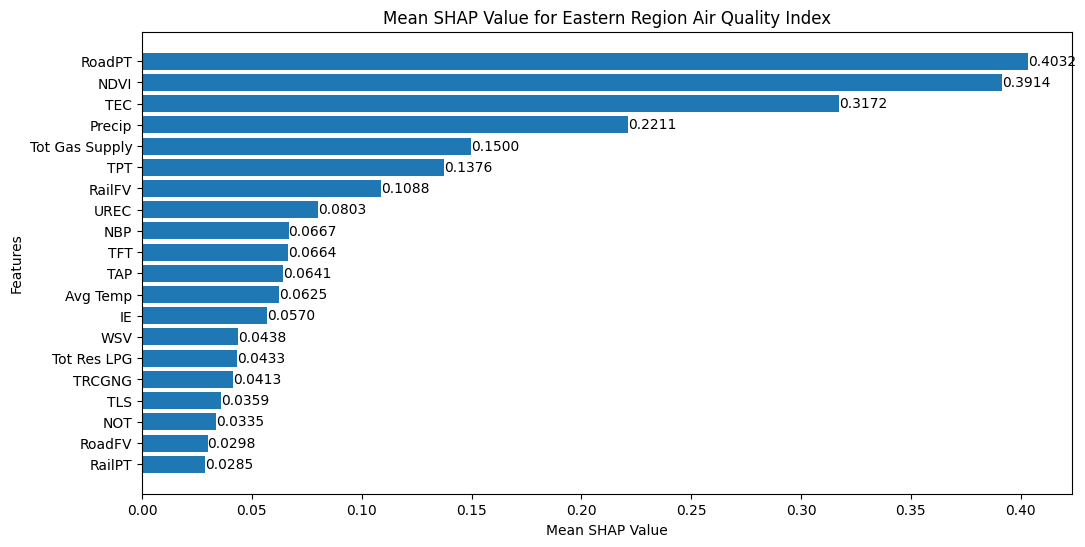

In [6]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 合并 X 数据（自然环境、交通、能源）
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year", "quyu"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex", "quyu"]].merge(x_data, on=["city", "year", "quyu"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 提取东部区域数据
final_data_cleaned = final_data_cleaned[final_data_cleaned["quyu"] == "西部"]

# 选择特征和目标变量
X = final_data_cleaned[feature_columns]
Y = final_data_cleaned["AirQualityIndex"]

# 处理非数值列
X = X.select_dtypes(include=[np.number])

# 确保包含全部20个特征
# 强制转换所有特征列为数值类型
for col in feature_columns:
    final_data_cleaned[col] = pd.to_numeric(final_data_cleaned[col], errors="coerce")

# 选择特征列
X = final_data_cleaned[feature_columns]

# 确保最终特征数量正确
print("最终 X 数据列名:", X.columns.tolist())
print("最终 X 特征数量:", X.shape[1])
assert X.shape[1] == 20, f"特征数量不匹配，当前数量: {X.shape[1]}，应为20"

# 训练 XGBoost 模型
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, Y)

# 计算 SHAP 值
explainer = shap.Explainer(model)
shap_values = explainer(X)

# 绘制 SHAP 值图
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X, max_display=20)
plt.show()

# 计算 SHAP 值的均值
shap_means = np.abs(shap_values.values).mean(axis=0)
shap_mean_df = pd.DataFrame({"Feature": X.columns, "Mean SHAP Value": shap_means})
shap_mean_df = shap_mean_df.sort_values(by="Mean SHAP Value", ascending=False)

# 绘制 SHAP 均值图，并在旁边标明具体数值
plt.figure(figsize=(12, 6))
plt.barh(shap_mean_df["Feature"], shap_mean_df["Mean SHAP Value"])
plt.xlabel("Mean SHAP Value")
plt.ylabel("Features")
plt.title("Mean SHAP Value for Eastern Region Air Quality Index")
plt.gca().invert_yaxis()

# 在图形旁边标明具体数值
for index, value in enumerate(shap_mean_df["Mean SHAP Value"]):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.show()


# 正负向影响

# 全局（不建议使用）

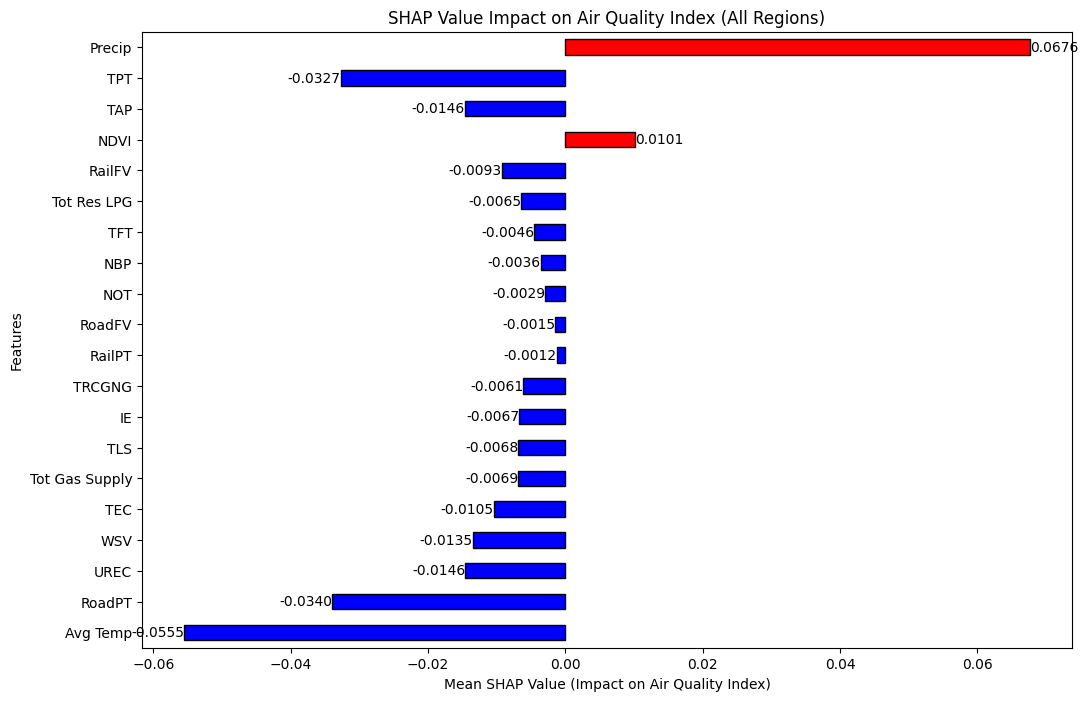

In [31]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

# 数据标准化
scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

# PCA 降维，生成 AirQualityIndex
pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 合并 X 数据（自然环境、交通、能源）
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year", "quyu"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex", "quyu"]].merge(x_data, on=["city", "year", "quyu"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 选择全区域数据
# 不过滤区域，选择所有区域的数据
final_data_cleaned_all = final_data_cleaned

# 选择特征和目标变量
X = final_data_cleaned_all[feature_columns]
Y = final_data_cleaned_all["AirQualityIndex"]

# 处理非数值列
X = X.select_dtypes(include=[np.number])

# 强制转换所有特征列为数值类型
for col in feature_columns:
    final_data_cleaned_all[col] = pd.to_numeric(final_data_cleaned_all[col], errors="coerce")

# 选择特征列
X = final_data_cleaned_all[feature_columns]

# 确保最终特征数量正确
assert X.shape[1] == 20, f"特征数量不匹配，当前数量: {X.shape[1]}，应为20"

# 训练 XGBoost 模型
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, Y)

# 计算 SHAP 值
explainer = shap.Explainer(model)
shap_values = explainer(X)

# 获取 SHAP 值的正负向影响
shap_values_df = pd.DataFrame(shap_values.values, columns=X.columns)

# 创建一个新的数据框，存储每个特征的 SHAP 值（正向/负向影响）
shap_summary = shap_values_df.mean(axis=0).sort_values(ascending=False)

# 动态判断每个特征的正负向影响
colors = []
for feature in shap_summary.index:
    if feature == "Precip":
        # 判断年均降水量在800-1200mm之间为正向影响
        if final_data_cleaned_all["Precip"].mean() >= 800 and final_data_cleaned_all["Precip"].mean() <= 1200:
            colors.append('red')  # 年均降水量为800-1200mm，正向影响
        else:
            colors.append('blue')  # 否则为负向影响
    elif feature == "Avg Temp":
        # 判断年均气温在24-26°C之间为正向影响
        if 24 <= final_data_cleaned_all["Avg Temp"].mean() <= 26:
            colors.append('red')  # 年均气温在24-26°C之间，正向影响
        else:
            colors.append('blue')  # 否则为负向影响
    elif feature == "NDVI":
        colors.append('red')  # 植被指数越高越好，正向影响
    else:
        colors.append('blue')  # 其他特征视为负向影响

# 调整 SHAP 值的符号
# 将正向影响的特征的 SHAP 值设置为正数，负向影响的特征的 SHAP 值设置为负数
for i, feature in enumerate(shap_summary.index):
    if colors[i] == 'red':  # 红色表示正向影响
        shap_summary[feature] = abs(shap_summary[feature])  # 正向影响，SHAP值为正
    else:  # 蓝色表示负向影响
        shap_summary[feature] = -abs(shap_summary[feature])  # 负向影响，SHAP值为负

# 绘制正负向关系图：显示每个特征对空气质量的正负向影响
plt.figure(figsize=(12, 8))

# 使用条形图显示正负向影响，正向影响红色，负向影响蓝色
shap_summary.plot(kind='barh', color=colors, edgecolor='black')

# 在条形旁边标注 SHAP 值，负向影响在条形左侧，正向影响在右侧
for index, value in enumerate(shap_summary):
    if value < 0:  # 负向影响（蓝色）
        plt.text(value, index, f'{value:.4f}', va='center', ha='right', fontsize=10, color='black')  # 文本放在左边
    else:  # 正向影响（红色）
        plt.text(value, index, f'{value:.4f}', va='center', ha='left', fontsize=10, color='black')  # 文本放在右边

plt.xlabel("Mean SHAP Value (Impact on Air Quality Index)")
plt.ylabel("Features")
plt.title("SHAP Value Impact on Air Quality Index (All Regions)")
plt.show()


# 东部

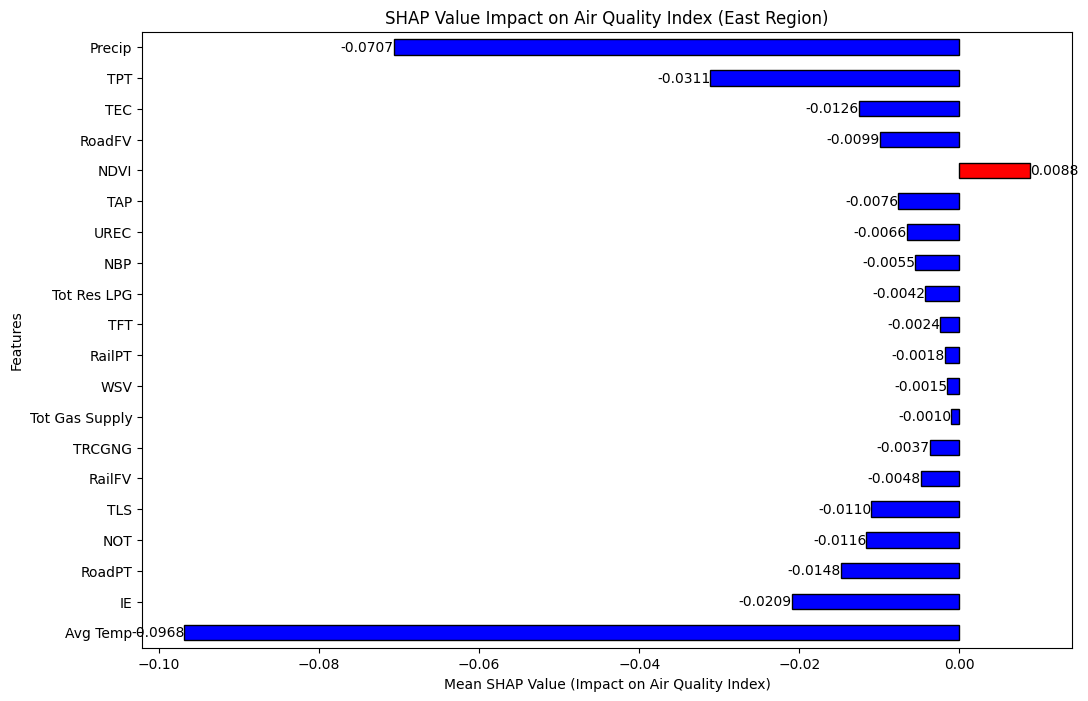

In [27]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

# 数据标准化
scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

# PCA 降维，生成 AirQualityIndex
pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 合并 X 数据（自然环境、交通、能源）
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year", "quyu"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex", "quyu"]].merge(x_data, on=["city", "year", "quyu"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 提取东部区域数据
final_data_cleaned = final_data_cleaned[final_data_cleaned["quyu"] == "东部"]

# 选择特征和目标变量
X = final_data_cleaned[feature_columns]
Y = final_data_cleaned["AirQualityIndex"]

# 处理非数值列
X = X.select_dtypes(include=[np.number])

# 强制转换所有特征列为数值类型
for col in feature_columns:
    final_data_cleaned[col] = pd.to_numeric(final_data_cleaned[col], errors="coerce")

# 选择特征列
X = final_data_cleaned[feature_columns]

# 确保最终特征数量正确
assert X.shape[1] == 20, f"特征数量不匹配，当前数量: {X.shape[1]}，应为20"

# 训练 XGBoost 模型
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, Y)

# 计算 SHAP 值
explainer = shap.Explainer(model)
shap_values = explainer(X)

# 获取 SHAP 值的正负向影响
shap_values_df = pd.DataFrame(shap_values.values, columns=X.columns)

# 创建一个新的数据框，存储每个特征的 SHAP 值（正向/负向影响）
shap_summary = shap_values_df.mean(axis=0).sort_values(ascending=False)

# 动态判断每个特征的正负向影响
colors = []
for feature in shap_summary.index:
    if feature == "Precip":
        # 判断年均降水量在800-1200mm之间为正向影响
        if final_data_cleaned["Precip"].mean() >= 800 and final_data_cleaned["Precip"].mean() <= 1200:
            colors.append('red')  # 年均降水量为800-1200mm，正向影响
        else:
            colors.append('blue')  # 否则为负向影响
    elif feature == "Avg Temp":
        # 判断年均气温在24-26°C之间为正向影响
        if 24 <= final_data_cleaned["Avg Temp"].mean() <= 26:
            colors.append('red')  # 年均气温在24-26°C之间，正向影响
        else:
            colors.append('blue')  # 否则为负向影响
    elif feature == "NDVI":
        colors.append('red')  # 植被指数越高越好，正向影响
    else:
        colors.append('blue')  # 其他特征视为负向影响

# 调整 SHAP 值的符号
# 将正向影响的特征的 SHAP 值设置为正数，负向影响的特征的 SHAP 值设置为负数
for i, feature in enumerate(shap_summary.index):
    if colors[i] == 'red':  # 红色表示正向影响
        shap_summary[feature] = abs(shap_summary[feature])  # 正向影响，SHAP值为正
    else:  # 蓝色表示负向影响
        shap_summary[feature] = -abs(shap_summary[feature])  # 负向影响，SHAP值为负

# 绘制正负向关系图：显示每个特征对空气质量的正负向影响
plt.figure(figsize=(12, 8))

# 使用条形图显示正负向影响，正向影响红色，负向影响蓝色
shap_summary.plot(kind='barh', color=colors, edgecolor='black')

# 在条形旁边标注 SHAP 值，负向影响在条形左侧，正向影响在右侧
for index, value in enumerate(shap_summary):
    if value < 0:  # 负向影响（蓝色）
        plt.text(value, index, f'{value:.4f}', va='center', ha='right', fontsize=10, color='black')  # 文本放在左边
    else:  # 正向影响（红色）
        plt.text(value, index, f'{value:.4f}', va='center', ha='left', fontsize=10, color='black')  # 文本放在右边

plt.xlabel("Mean SHAP Value (Impact on Air Quality Index)")
plt.ylabel("Features")
plt.title("SHAP Value Impact on Air Quality Index (East Region)")
plt.show()


# 东北

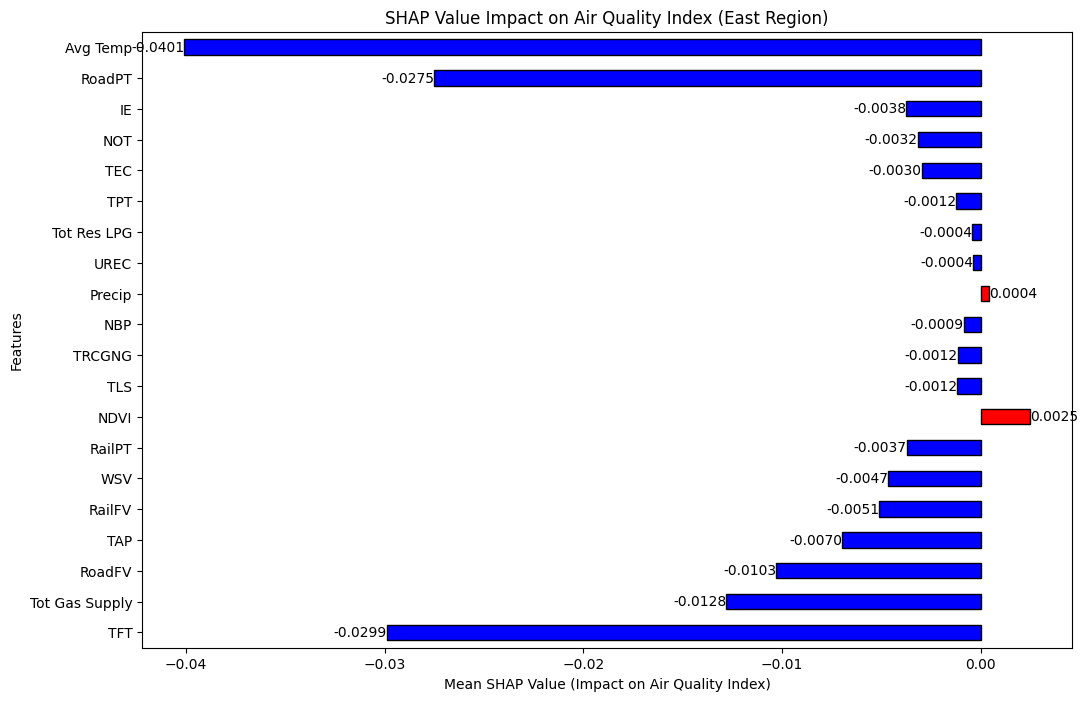

In [28]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

# 数据标准化
scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

# PCA 降维，生成 AirQualityIndex
pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 合并 X 数据（自然环境、交通、能源）
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year", "quyu"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex", "quyu"]].merge(x_data, on=["city", "year", "quyu"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 提取东部区域数据
final_data_cleaned = final_data_cleaned[final_data_cleaned["quyu"] == "东北"]

# 选择特征和目标变量
X = final_data_cleaned[feature_columns]
Y = final_data_cleaned["AirQualityIndex"]

# 处理非数值列
X = X.select_dtypes(include=[np.number])

# 强制转换所有特征列为数值类型
for col in feature_columns:
    final_data_cleaned[col] = pd.to_numeric(final_data_cleaned[col], errors="coerce")

# 选择特征列
X = final_data_cleaned[feature_columns]

# 确保最终特征数量正确
assert X.shape[1] == 20, f"特征数量不匹配，当前数量: {X.shape[1]}，应为20"

# 训练 XGBoost 模型
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, Y)

# 计算 SHAP 值
explainer = shap.Explainer(model)
shap_values = explainer(X)

# 获取 SHAP 值的正负向影响
shap_values_df = pd.DataFrame(shap_values.values, columns=X.columns)

# 创建一个新的数据框，存储每个特征的 SHAP 值（正向/负向影响）
shap_summary = shap_values_df.mean(axis=0).sort_values(ascending=False)

# 动态判断每个特征的正负向影响
colors = []
for feature in shap_summary.index:
    if feature == "Precip":
        # 判断年均降水量在800-1200mm之间为正向影响
        if final_data_cleaned["Precip"].mean() >= 800 and final_data_cleaned["Precip"].mean() <= 1200:
            colors.append('red')  # 年均降水量为800-1200mm，正向影响
        else:
            colors.append('blue')  # 否则为负向影响
    elif feature == "Avg Temp":
        # 判断年均气温在24-26°C之间为正向影响
        if 24 <= final_data_cleaned["Avg Temp"].mean() <= 26:
            colors.append('red')  # 年均气温在24-26°C之间，正向影响
        else:
            colors.append('blue')  # 否则为负向影响
    elif feature == "NDVI":
        colors.append('red')  # 植被指数越高越好，正向影响
    else:
        colors.append('blue')  # 其他特征视为负向影响

# 调整 SHAP 值的符号
# 将正向影响的特征的 SHAP 值设置为正数，负向影响的特征的 SHAP 值设置为负数
for i, feature in enumerate(shap_summary.index):
    if colors[i] == 'red':  # 红色表示正向影响
        shap_summary[feature] = abs(shap_summary[feature])  # 正向影响，SHAP值为正
    else:  # 蓝色表示负向影响
        shap_summary[feature] = -abs(shap_summary[feature])  # 负向影响，SHAP值为负

# 绘制正负向关系图：显示每个特征对空气质量的正负向影响
plt.figure(figsize=(12, 8))

# 使用条形图显示正负向影响，正向影响红色，负向影响蓝色
shap_summary.plot(kind='barh', color=colors, edgecolor='black')

# 在条形旁边标注 SHAP 值，负向影响在条形左侧，正向影响在右侧
for index, value in enumerate(shap_summary):
    if value < 0:  # 负向影响（蓝色）
        plt.text(value, index, f'{value:.4f}', va='center', ha='right', fontsize=10, color='black')  # 文本放在左边
    else:  # 正向影响（红色）
        plt.text(value, index, f'{value:.4f}', va='center', ha='left', fontsize=10, color='black')  # 文本放在右边

plt.xlabel("Mean SHAP Value (Impact on Air Quality Index)")
plt.ylabel("Features")
plt.title("SHAP Value Impact on Air Quality Index (East Region)")
plt.show()


# 中部

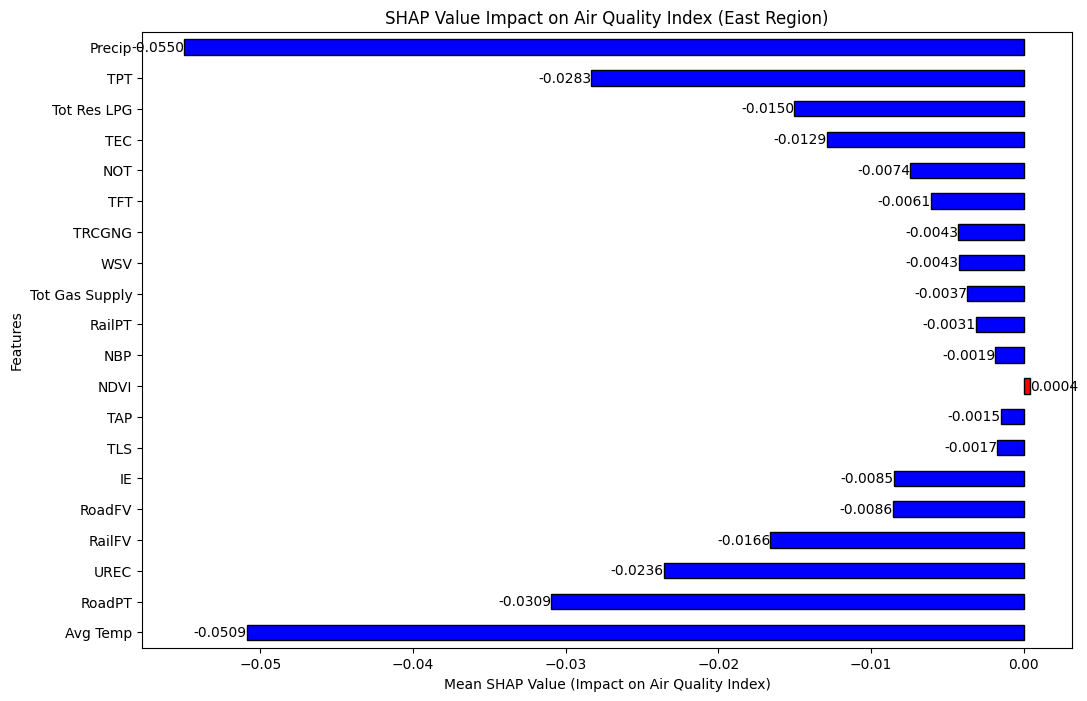

In [29]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

# 数据标准化
scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

# PCA 降维，生成 AirQualityIndex
pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 合并 X 数据（自然环境、交通、能源）
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year", "quyu"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex", "quyu"]].merge(x_data, on=["city", "year", "quyu"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 提取东部区域数据
final_data_cleaned = final_data_cleaned[final_data_cleaned["quyu"] == "中部"]

# 选择特征和目标变量
X = final_data_cleaned[feature_columns]
Y = final_data_cleaned["AirQualityIndex"]

# 处理非数值列
X = X.select_dtypes(include=[np.number])

# 强制转换所有特征列为数值类型
for col in feature_columns:
    final_data_cleaned[col] = pd.to_numeric(final_data_cleaned[col], errors="coerce")

# 选择特征列
X = final_data_cleaned[feature_columns]

# 确保最终特征数量正确
assert X.shape[1] == 20, f"特征数量不匹配，当前数量: {X.shape[1]}，应为20"

# 训练 XGBoost 模型
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, Y)

# 计算 SHAP 值
explainer = shap.Explainer(model)
shap_values = explainer(X)

# 获取 SHAP 值的正负向影响
shap_values_df = pd.DataFrame(shap_values.values, columns=X.columns)

# 创建一个新的数据框，存储每个特征的 SHAP 值（正向/负向影响）
shap_summary = shap_values_df.mean(axis=0).sort_values(ascending=False)

# 动态判断每个特征的正负向影响
colors = []
for feature in shap_summary.index:
    if feature == "Precip":
        # 判断年均降水量在800-1200mm之间为正向影响
        if final_data_cleaned["Precip"].mean() >= 800 and final_data_cleaned["Precip"].mean() <= 1200:
            colors.append('red')  # 年均降水量为800-1200mm，正向影响
        else:
            colors.append('blue')  # 否则为负向影响
    elif feature == "Avg Temp":
        # 判断年均气温在24-26°C之间为正向影响
        if 24 <= final_data_cleaned["Avg Temp"].mean() <= 26:
            colors.append('red')  # 年均气温在24-26°C之间，正向影响
        else:
            colors.append('blue')  # 否则为负向影响
    elif feature == "NDVI":
        colors.append('red')  # 植被指数越高越好，正向影响
    else:
        colors.append('blue')  # 其他特征视为负向影响

# 调整 SHAP 值的符号
# 将正向影响的特征的 SHAP 值设置为正数，负向影响的特征的 SHAP 值设置为负数
for i, feature in enumerate(shap_summary.index):
    if colors[i] == 'red':  # 红色表示正向影响
        shap_summary[feature] = abs(shap_summary[feature])  # 正向影响，SHAP值为正
    else:  # 蓝色表示负向影响
        shap_summary[feature] = -abs(shap_summary[feature])  # 负向影响，SHAP值为负

# 绘制正负向关系图：显示每个特征对空气质量的正负向影响
plt.figure(figsize=(12, 8))

# 使用条形图显示正负向影响，正向影响红色，负向影响蓝色
shap_summary.plot(kind='barh', color=colors, edgecolor='black')

# 在条形旁边标注 SHAP 值，负向影响在条形左侧，正向影响在右侧
for index, value in enumerate(shap_summary):
    if value < 0:  # 负向影响（蓝色）
        plt.text(value, index, f'{value:.4f}', va='center', ha='right', fontsize=10, color='black')  # 文本放在左边
    else:  # 正向影响（红色）
        plt.text(value, index, f'{value:.4f}', va='center', ha='left', fontsize=10, color='black')  # 文本放在右边

plt.xlabel("Mean SHAP Value (Impact on Air Quality Index)")
plt.ylabel("Features")
plt.title("SHAP Value Impact on Air Quality Index (East Region)")
plt.show()


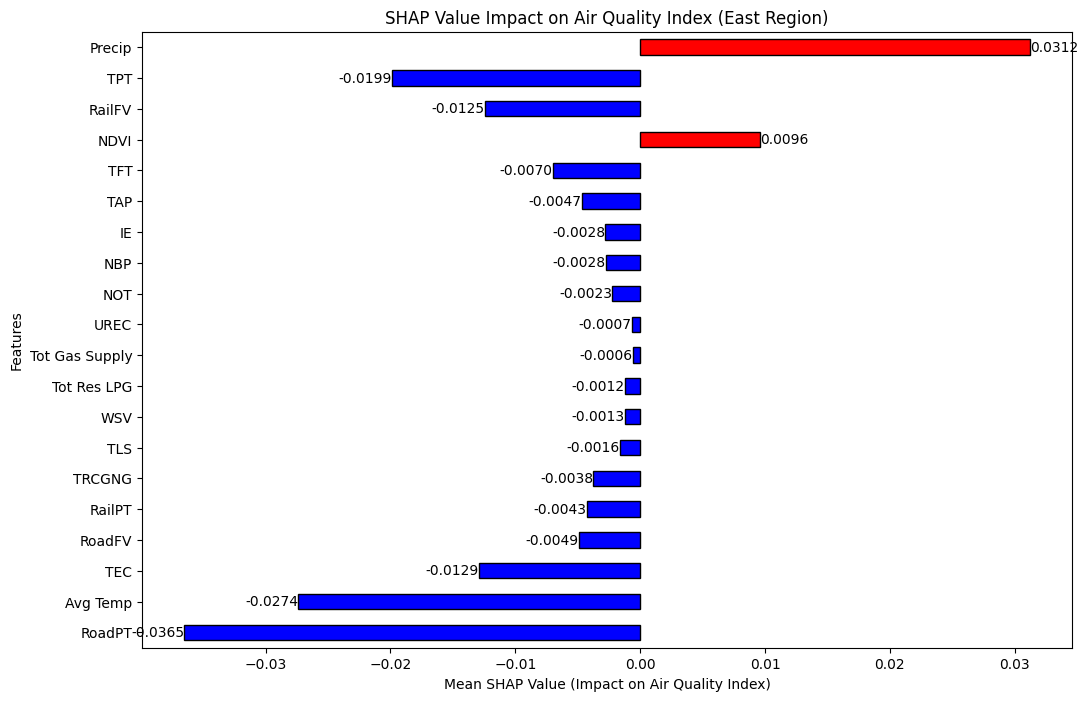

In [30]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

# 数据标准化
scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

# PCA 降维，生成 AirQualityIndex
pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 合并 X 数据（自然环境、交通、能源）
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year", "quyu"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex", "quyu"]].merge(x_data, on=["city", "year", "quyu"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 提取东部区域数据
final_data_cleaned = final_data_cleaned[final_data_cleaned["quyu"] == "西部"]

# 选择特征和目标变量
X = final_data_cleaned[feature_columns]
Y = final_data_cleaned["AirQualityIndex"]

# 处理非数值列
X = X.select_dtypes(include=[np.number])

# 强制转换所有特征列为数值类型
for col in feature_columns:
    final_data_cleaned[col] = pd.to_numeric(final_data_cleaned[col], errors="coerce")

# 选择特征列
X = final_data_cleaned[feature_columns]

# 确保最终特征数量正确
assert X.shape[1] == 20, f"特征数量不匹配，当前数量: {X.shape[1]}，应为20"

# 训练 XGBoost 模型
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, Y)

# 计算 SHAP 值
explainer = shap.Explainer(model)
shap_values = explainer(X)

# 获取 SHAP 值的正负向影响
shap_values_df = pd.DataFrame(shap_values.values, columns=X.columns)

# 创建一个新的数据框，存储每个特征的 SHAP 值（正向/负向影响）
shap_summary = shap_values_df.mean(axis=0).sort_values(ascending=False)

# 动态判断每个特征的正负向影响
colors = []
for feature in shap_summary.index:
    if feature == "Precip":
        # 判断年均降水量在800-1200mm之间为正向影响
        if final_data_cleaned["Precip"].mean() >= 800 and final_data_cleaned["Precip"].mean() <= 1200:
            colors.append('red')  # 年均降水量为800-1200mm，正向影响
        else:
            colors.append('blue')  # 否则为负向影响
    elif feature == "Avg Temp":
        # 判断年均气温在24-26°C之间为正向影响
        if 24 <= final_data_cleaned["Avg Temp"].mean() <= 26:
            colors.append('red')  # 年均气温在24-26°C之间，正向影响
        else:
            colors.append('blue')  # 否则为负向影响
    elif feature == "NDVI":
        colors.append('red')  # 植被指数越高越好，正向影响
    else:
        colors.append('blue')  # 其他特征视为负向影响

# 调整 SHAP 值的符号
# 将正向影响的特征的 SHAP 值设置为正数，负向影响的特征的 SHAP 值设置为负数
for i, feature in enumerate(shap_summary.index):
    if colors[i] == 'red':  # 红色表示正向影响
        shap_summary[feature] = abs(shap_summary[feature])  # 正向影响，SHAP值为正
    else:  # 蓝色表示负向影响
        shap_summary[feature] = -abs(shap_summary[feature])  # 负向影响，SHAP值为负

# 绘制正负向关系图：显示每个特征对空气质量的正负向影响
plt.figure(figsize=(12, 8))

# 使用条形图显示正负向影响，正向影响红色，负向影响蓝色
shap_summary.plot(kind='barh', color=colors, edgecolor='black')

# 在条形旁边标注 SHAP 值，负向影响在条形左侧，正向影响在右侧
for index, value in enumerate(shap_summary):
    if value < 0:  # 负向影响（蓝色）
        plt.text(value, index, f'{value:.4f}', va='center', ha='right', fontsize=10, color='black')  # 文本放在左边
    else:  # 正向影响（红色）
        plt.text(value, index, f'{value:.4f}', va='center', ha='left', fontsize=10, color='black')  # 文本放在右边

plt.xlabel("Mean SHAP Value (Impact on Air Quality Index)")
plt.ylabel("Features")
plt.title("SHAP Value Impact on Air Quality Index (East Region)")
plt.show()


In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import spearmanr

# 假设你有一个完整的数据框，包含了各个区域的数据
# 例如：final_data_cleaned_all 包含了所有区域的数据
# final_data_cleaned_all = final_data_cleaned_all.dropna()  # 删除任何缺失值

# 提取各区域数据（全区域、东北、东部、中部、西部）
regions = ['全区域', '东北', '东部', '中部', '西部']
region_data = {region: final_data_cleaned_all[final_data_cleaned_all['东部'] == region] for region in regions}

# 初始化一个 5x1 的子图
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# 计算每个区域的 Spearman 相关系数矩阵，并绘制热力图
for idx, region in enumerate(regions):
    data = region_data[region].drop(['city', 'year', 'quyu'], axis=1)  # 删除非数值列
    
    # 计算 Spearman 相关系数矩阵
    corr_matrix, _ = spearmanr(data, axis=0)
    
    # 计算层次聚类
    linkage_matrix = linkage(corr_matrix, method='ward')
    
    # 绘制热力图
    sns.heatmap(corr_matrix, ax=axes[idx], cmap='coolwarm', vmin=-1, vmax=1,
                cbar_kws={'label': "Spearman's r"}, square=True, annot=False, 
                xticklabels=data.columns, yticklabels=data.columns)
    
    # 添加聚类树状图
    dendrogram(linkage_matrix, ax=axes[idx], orientation='top', labels=data.columns, color_threshold=0)

    axes[idx].set_title(f'{region} Correlation', fontsize=14)

# 调整布局
plt.tight_layout()
plt.show()


KeyError: '东部'